In [ ]:
#| default_exp adapters.prophet

# FB-Prophet Adapter

> In 2017, Facebook open-sourced [Prophet](https://peerj.com/preprints/3190.pdf), with the promise of providing experts and non-experts the possibility of producing high-quality predictions. The forecasting community heavily adopted the solution, reaching millions of accumulated downloads. It became evident that its [quality is shadowed](https://www.reddit.com/r/MachineLearning/comments/wqrw8x/d_fool_me_once_shame_on_you_fool_me_twice_shame/) by simpler well-proven methods. This effort aims to provide an alternative to overcome the Prophet's memory.<br><br><div align="center">"It is important to note that false prophets sometimes prophesied accurately, ... " <br>(Deuteronomy 13:2,5) </div>

In [ ]:
#| hide
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nbdev.showdoc import show_doc

In [ ]:
#| export
import sys
from copy import deepcopy

import pandas as pd
from statsforecast.arima import AutoARIMA

if sys.version_info.minor != 6 or (sys.platform not in ['win32', 'cygwin']): 
    try: 
        from prophet import Prophet
    except ModuleNotFoundError as e:
        msg = (
            '{e}. To use prophet adapters you have to install '
            'prophet. Please run `pip install prophet`. '
            'Note that it is recommended to install prophet '
            'using conda environments due to dependencies.'
        )
        raise ModuleNotFoundError(msg) from e
elif sys.version_info.minor == 6 and (sys.platform in ['win32', 'cygwin']):
    try: 
        from fbprophet import Prophet
    except ModuleNotFoundError as e:
        msg = (
            '{e}. To use prophet adapters you have to install '
            'fbprophet. Please run `pip install fbprophet`. '
            'Note that it is recommended to install prophet '
            'using conda environments due to dependencies.'
        )
        raise ModuleNotFoundError(msg) from e

# <span style="color:DarkBlue">1. AutoARIMA Adapter </span>

## AutoArimaProphet

In [ ]:
#| export
class AutoARIMAProphet(Prophet):
    """AutoARIMAProphet adapter.

    Returns best ARIMA model using external variables created by the Prophet interface.
    This class receives as parameters the same as prophet.Prophet and uses a `models.AutoARIMA`
    backend.

    If your forecasting pipeline uses Prophet the `AutoARIMAProphet` adapter helps to
    easily substitute Prophet with an AutoARIMA.

    **Parameters:**<br>
    `growth`: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or flat trend.<br>
    `changepoints`: List of dates of potential changepoints. Otherwise selected automatically.<br>
    `n_changepoints`: Number of potential changepoints to include.<br>
    `changepoint_range`: Proportion of history in which trend changepoints will be estimated.<br>
    `yearly_seasonality`: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
    `weekly_seasonality`: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
    `daily_seasonality`: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
    `holidays`: pandas.DataFrame with columns holiday (string) and ds (date type).<br>
    `interval_width`: float, uncertainty forecast intervals width. `StatsForecast`'s level <br>

    **Notes:**<br>
    You can create automated exogenous variables from the Prophet data processing pipeline
    these exogenous will be included into `AutoARIMA`'s exogenous features. Parameters like 
    `seasonality_mode`, `seasonality_prior_scale`, `holidays_prior_scale`, `changepoint_prior_scale`,
    `mcmc_samples`, `uncertainty_samples`, `stan_backend` are Prophet exclusive.

    **References:**<br>
    [Sean J. Taylor, Benjamin Letham (2017). "Prophet Forecasting at Scale"](https://peerj.com/preprints/3190.pdf)
    
    [Oskar Triebe, Hansika Hewamalage, Polina Pilyugina, Nikolay Laptev, Christoph Bergmeir, Ram Rajagopal (2021). "NeuralProphet: Explainable Forecasting at Scale".](https://arxiv.org/pdf/2111.15397.pdf)

    [Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).
    """
    def __init__(self, 
                 growth='linear',
                 changepoints=None,
                 n_changepoints=25,
                 changepoint_range=0.8,
                 yearly_seasonality='auto',
                 weekly_seasonality='auto',
                 daily_seasonality='auto',
                 holidays=None,
                 seasonality_mode='additive',
                 seasonality_prior_scale=10.0,
                 holidays_prior_scale=10.0,
                 changepoint_prior_scale=0.05,
                 mcmc_samples=0,
                 interval_width=0.80,
                 uncertainty_samples=1000,
                 stan_backend=None,
                 d=None,
                 D=None,
                 max_p=5,
                 max_q=5,
                 max_P= 2,
                 max_Q= 2,
                 max_order= 5,
                 max_d=2,
                 max_D=1,
                 start_p=2,
                 start_q=2,
                 start_P=1,
                 start_Q=1,
                 stationary=False,
                 seasonal=True,
                 ic='aicc',
                 stepwise=True,
                 nmodels=94,
                 trace=False,
                 approximation=False,
                 method=None,
                 truncate=None,
                 test='kpss',
                 test_kwargs=None,
                 seasonal_test='seas',
                 seasonal_test_kwargs=None,
                 allowdrift=False,
                 allowmean=False,
                 blambda=None,
                 biasadj=False,
                 parallel=False,
                 num_cores=2,
                 period=1):
        Prophet.__init__(self,
                         growth,
                         changepoints,
                         n_changepoints,
                         changepoint_range,
                         yearly_seasonality,
                         weekly_seasonality,
                         daily_seasonality,
                         holidays,
                         seasonality_mode,
                         seasonality_prior_scale,
                         holidays_prior_scale,
                         changepoint_prior_scale,
                         mcmc_samples,
                         interval_width,
                         uncertainty_samples,
                         stan_backend)
        self.arima = AutoARIMA(d=d,
                               D=D,
                               max_p=max_p,
                               max_q=max_q,
                               max_P=max_P,
                               max_Q=max_Q,
                               max_order=max_order,
                               max_d=max_d,
                               max_D=max_D,
                               start_p=start_p,
                               start_q=start_q,
                               start_P=start_P,
                               start_Q=start_Q,
                               stationary=stationary,
                               seasonal=seasonal,
                               ic=ic,
                               stepwise=stepwise,
                               nmodels=nmodels,
                               trace=trace,
                               approximation=approximation,
                               method=method,
                               truncate=truncate,
                               test=test,
                               test_kwargs=test_kwargs,
                               seasonal_test=seasonal_test,
                               seasonal_test_kwargs=seasonal_test_kwargs,
                               allowdrift=allowdrift,
                               allowmean=allowmean,
                               blambda=blambda,
                               biasadj=biasadj,
                               parallel=parallel,
                               num_cores=num_cores,
                               period=period)
    
    def fit(self, df, disable_seasonal_features=True, **kwargs):
        """Fit the AutoARIMAProphet adapter.

        **Parameters:**<br>
        `df`: pandas.DataFrame, with columns ds (date type) and y, the time series.<br>
        `disable_seasonal_features`: bool, Wheter disable Prophet's seasonal features.<br>
        `kwargs`: Additional arguments.<br>
        
        **Returns:**<br>
        `self`: `AutoARIMAProphet` adapter object with `AutoARIMA` fitted model.
        """
        if self.history is not None:
            raise Exception('Prophet object can only be fit once. '
                            'Instantiate a new object.')
        if ('ds' not in df) or ('y' not in df):
            raise ValueError(
                'Dataframe must have columns "ds" and "y" with the dates and '
                'values respectively.'
            )
        history = df[df['y'].notnull()].copy()
        if history.shape[0] < 2:
            raise ValueError('Dataframe has less than 2 non-NaN rows.')
        self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()

        history = self.setup_dataframe(history, initialize_scales=True)
        self.history = history
        self.set_auto_seasonalities()
        seasonal_features, prior_scales, component_cols, modes = (
            self.make_all_seasonality_features(history))
        self.train_component_cols = component_cols
        self.component_modes = modes
        self.fit_kwargs = deepcopy(kwargs)
        if disable_seasonal_features:
            seas = tuple(self.seasonalities.keys())
            seasonal_features = seasonal_features.loc[:,~seasonal_features.columns.str.startswith(seas)]
        self.xreg_cols = seasonal_features.columns
        
        y = history['y'].values
        X = seasonal_features.values if not seasonal_features.empty else None
        self.arima = self.arima.fit(y=y, X=X)

        return self

    def predict(self, df=None):
        """Predict using the AutoARIMAProphet adapter.
        
        **Parameters:**<br>
        `df`: pandas.DataFrame, with columns ds (date type) and y, the time series.<br>
            
        **Returns:**<br>
        `fcsts_df`: A pandas.DataFrame with the forecast components.
        """
        if self.history is None:
            raise Exception('Model has not been fit.')

        if df is None:
            df = self.history.copy()
        else:
            if df.shape[0] == 0:
                raise ValueError('Dataframe has no rows.')
            df = self.setup_dataframe(df.copy())
            
        seasonal_features = self.make_all_seasonality_features(df)[0].loc[:, self.xreg_cols]
        
        ds_forecast = set(df['ds'])
        h = len(ds_forecast - set(self.history['ds']))
        if h > 0:
            X = seasonal_features.values[-h:] if not seasonal_features.empty else None
            fcsts_df = self.arima.predict(h=h, X=X,
                                          level=int(100*self.interval_width))
        else:
            fcsts_df = pd.DataFrame()
        if len(ds_forecast) > h: 
            in_sample = self.arima.predict_in_sample(level=int(100*self.interval_width))
            fcsts_df = pd.concat([in_sample, fcsts_df]).reset_index(drop=True)

        yhat = fcsts_df.pop('mean')
        fcsts_df.columns = ['yhat_lower', 'yhat_upper']
        fcsts_df.insert(0, 'yhat', yhat)
        fcsts_df.insert(0, 'ds', df['ds'])
            
        return fcsts_df

In [ ]:
show_doc(AutoARIMAProphet, title_level=3)

---

### AutoARIMAProphet

>      AutoARIMAProphet (growth='linear', changepoints=None, n_changepoints=25,
>                        changepoint_range=0.8, yearly_seasonality='auto',
>                        weekly_seasonality='auto', daily_seasonality='auto',
>                        holidays=None, seasonality_mode='additive',
>                        seasonality_prior_scale=10.0,
>                        holidays_prior_scale=10.0,
>                        changepoint_prior_scale=0.05, mcmc_samples=0,
>                        interval_width=0.8, uncertainty_samples=1000,
>                        stan_backend=None, d=None, D=None, max_p=5, max_q=5,
>                        max_P=2, max_Q=2, max_order=5, max_d=2, max_D=1,
>                        start_p=2, start_q=2, start_P=1, start_Q=1,
>                        stationary=False, seasonal=True, ic='aicc',
>                        stepwise=True, nmodels=94, trace=False,
>                        approximation=False, method=None, truncate=None,
>                        test='kpss', test_kwargs=None, seasonal_test='seas',
>                        seasonal_test_kwargs=None, allowdrift=False,
>                        allowmean=False, blambda=None, biasadj=False,
>                        parallel=False, num_cores=2, period=1)

AutoARIMAProphet adapter.

Returns best ARIMA model using external variables created by the Prophet interface.
This class receives as parameters the same as prophet.Prophet and uses a `models.AutoARIMA`
backend.

If your forecasting pipeline uses Prophet the `AutoARIMAProphet` adapter helps to
easily substitute Prophet with an AutoARIMA.

**Parameters:**<br>
`growth`: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or flat trend.<br>
`changepoints`: List of dates of potential changepoints. Otherwise selected automatically.<br>
`n_changepoints`: Number of potential changepoints to include.<br>
`changepoint_range`: Proportion of history in which trend changepoints will be estimated.<br>
`yearly_seasonality`: Fit yearly seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
`weekly_seasonality`: Fit weekly seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
`daily_seasonality`: Fit daily seasonality.
    Can be 'auto', True, False, or a number of Fourier terms to generate.<br>
`holidays`: pandas.DataFrame with columns holiday (string) and ds (date type).<br>
`interval_width`: float, uncertainty forecast intervals width. `StatsForecast`'s level <br>

**Notes:**<br>
You can create automated exogenous variables from the Prophet data processing pipeline
these exogenous will be included into `AutoARIMA`'s exogenous features. Parameters like 
`seasonality_mode`, `seasonality_prior_scale`, `holidays_prior_scale`, `changepoint_prior_scale`,
`mcmc_samples`, `uncertainty_samples`, `stan_backend` are Prophet exclusive.

**References:**<br>
[Sean J. Taylor, Benjamin Letham (2017). "Prophet Forecasting at Scale"](https://peerj.com/preprints/3190.pdf)

[Oskar Triebe, Hansika Hewamalage, Polina Pilyugina, Nikolay Laptev, Christoph Bergmeir, Ram Rajagopal (2021). "NeuralProphet: Explainable Forecasting at Scale".](https://arxiv.org/pdf/2111.15397.pdf)

[Rob J. Hyndman, Yeasmin Khandakar (2008). "Automatic Time Series Forecasting: The forecast package for R"](https://www.jstatsoft.org/article/view/v027i03).

In [ ]:
show_doc(AutoARIMAProphet.fit, title_level=3)

---

### AutoARIMAProphet.fit

>      AutoARIMAProphet.fit (df, disable_seasonal_features=True, **kwargs)

Fit the AutoARIMAProphet adapter.

**Parameters:**<br>
`df`: pandas.DataFrame, with columns ds (date type) and y, the time series.<br>
`disable_seasonal_features`: bool, Wheter disable Prophet's seasonal features.<br>
`kwargs`: Additional arguments.<br>

**Returns:**<br>
`self`: `AutoARIMAProphet` adapter object with `AutoARIMA` fitted model.

In [ ]:
show_doc(AutoARIMAProphet.predict, title_level=3)

---

### AutoARIMAProphet.predict

>      AutoARIMAProphet.predict (df=None)

Predict using the AutoARIMAProphet adapter.

**Parameters:**<br>
`df`: pandas.DataFrame, with columns ds (date type) and y, the time series.<br>
    
**Returns:**<br>
`fcsts_df`: A pandas.DataFrame with the forecast components.

# <span style="color:DarkBlue">2. Prophet Substitution Example </span>

### Quick Start

In this example, we revisit the time series of the log daily page views for the Wikipedia page for [Peyton Manning](https://en.wikipedia.org/wiki/Peyton_Manning). The dataset was scraped this data using the [WikipediaTrend](https://cran.r-project.org/web/packages/wikipediatrend/index.html) package in R.

The Peyton Manning dataset was selected to illustrate Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning's playoff and SuperBowl appearances). The original CSV is available [here](https://github.com/facebook/prophet/blob/main/examples/example_wp_log_peyton_manning.csv).

Here we show that `AutoARIMA` can improve performance by borrowing the `Prophet`'s feature preprocessing.

### Inputs

The `AutoARIMAProphet` adapter uses `Prophet`'s inputs, a pandas dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally 'YYYY-MM-DD' for a date or 'YYYY-MM-DD HH:MM:SS' for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


## <span style="color:DarkBlue">2.1 Univariate Prophet </span>

Here we forecast with `Prophet` without external regressors. We first instantiate a new `Prophet` object, and define its forecasting procedure into its constructor. After that a classic sklearn `fit` and `predict` is used to obtain the predictions.

In [ ]:
m = Prophet(daily_seasonality=False)
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7975.31    0.00415855       247.015      0.7831      0.7831      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7994.53      0.010249        344.02           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       7995.33   5.91718e-05       165.006   4.517e-07       0.001      316  LS failed, Hessian reset 
     299       7997.26   0.000813407       209.659       6.754      0.6754      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        8001.1   0.000792021       147.659      0.5991           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     488       8002.21   7.22552e-05    

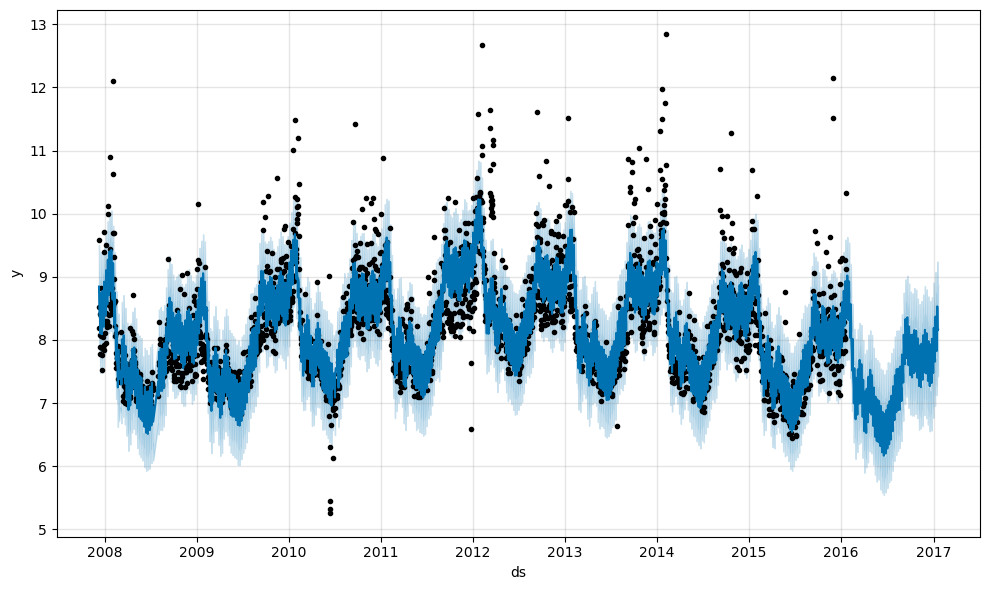

In [ ]:
fig = m.plot(forecast)

Here we forecast with `AutoARIMAProphet` adapter without external regressors. It inherits the `Prophet` constructor as well as its `fit` and `predict` methods. 

With the class `AutoARIMAProphet` you can simply substitute `Prophet` and you'll be training an `AutoARIMA` model without changing anything in your forecasting pipeline.

In [ ]:
%%capture
m = AutoARIMAProphet(daily_seasonality=False)
m.fit(df)
# m.fit(df, disable_seasonal_features=False) # Uncomment for better AutoARIMA predictions
future = m.make_future_dataframe(365)
forecast = m.predict(future)

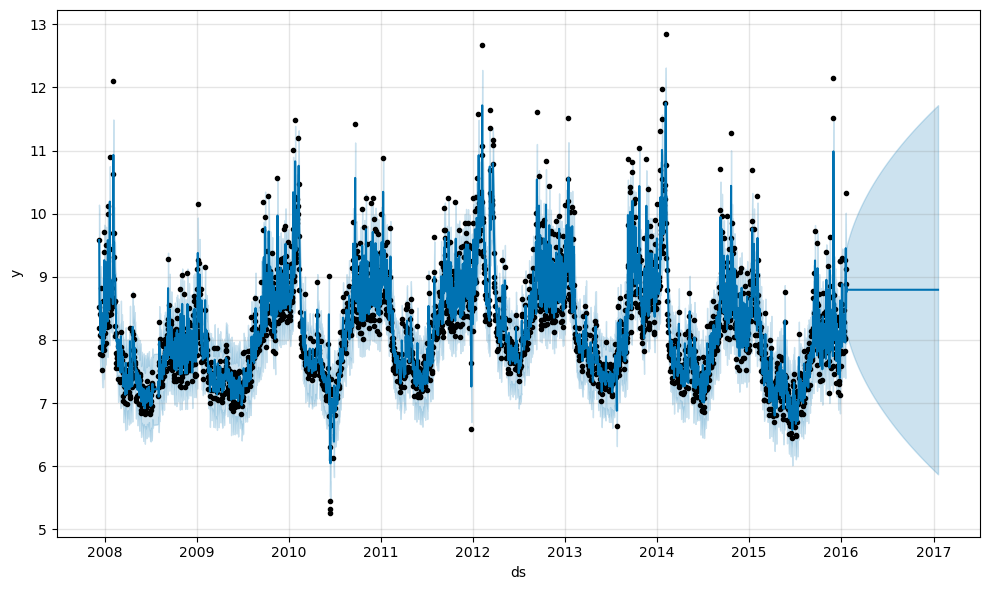

In [ ]:
fig = m.plot(forecast)

## <span style="color:DarkBlue">2.2 Holiday Prophet </span>

Usually `Prophet` pipelines include the usage of external regressors such as **holidays**.

Suppose you want to include holidays or other recurring calendar events, you can create a pandas.DataFrame for them. The DataFrame needs two columns [`holiday`, `ds`] and a row for each holiday. It requires all the occurrences of the holiday (as far as the historical data allows) and the future events of the holiday. If the future does not have the holidays registered, they will be modeled but not included in the forecast.

You can also include into the events DataFrame, `lower_window` and `upper_window` that extends the effect of the holidays through dates to [`lower_window`, `upper_window`] days around the date. For example if you wanted to account for Christmas Eve in addition to Christmas you’d include `lower_window=-1`,`upper_window=0`, or Black Friday in addition to Thanksgiving, you’d include `lower_window=0`,`upper_window=1`.

Here we Peyton Manning’s playoff appearances dates:

In [ ]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [ ]:
%%capture
m = Prophet(daily_seasonality=False, holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
future = m.make_future_dataframe(365)
forecast = m.predict(future)

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        8150.2   0.000979196       233.682           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8174.12    0.00247748       159.055           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        8179.3    0.00329967       328.786      0.3221           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          8184   0.000738138       251.279       0.531           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8185.23   0.000177823       98.3728      0.9371      0.9371      623   
    Iter      log prob        ||dx||      ||grad||       alpha  

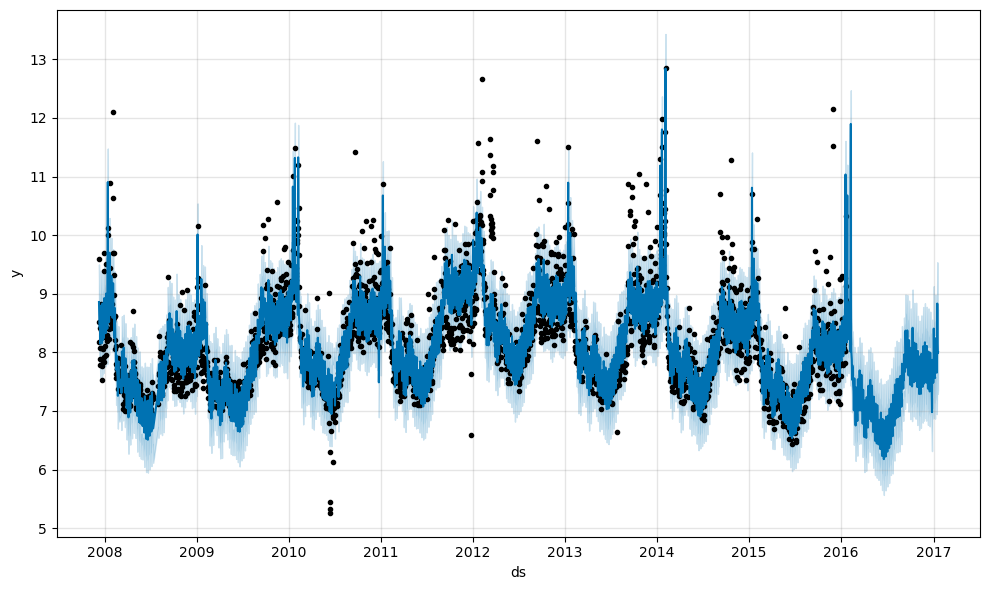

In [ ]:
fig = m.plot(forecast)

The class `AutoARIMAProphet` adapter allows to handle these scenarios to fit an `AutoARIMA` model with exogenous variables.

You can enjoy your Prophet pipelines with the improved performance of a classic ARIMA.

In [ ]:
%%capture
m = AutoARIMAProphet(daily_seasonality=False,
                     holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)
# m.fit(df, disable_seasonal_features=False) # Uncomment for better AutoARIMA predictions
future = m.make_future_dataframe(365)
forecast = m.predict(future)

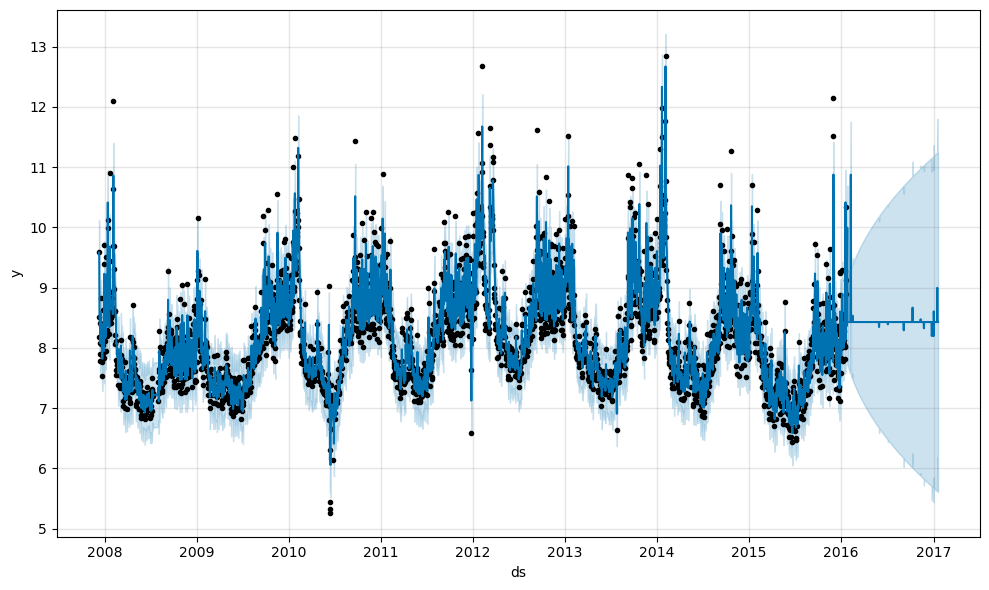

In [ ]:
fig = m.plot(forecast)